# [Allstate Claims Severity](https://bit.ly/2PkuKj5)
 
### Celem jest zastosować sieci neuronowe wspólnie z boostingiem.

To już pewnie znany Ci problem. Wiesz, jak podejść do niego używając klasycznego uczenia maszynowego (np. XGBoost). Ciekawostka jest taka, że również można zastosować sieci neuronowe.

Co prawda daje to trochę gorszy wynik, natomiast w połączeniu z boostingiem (w tym przypadku) daje to lepszy rezultat.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold

#Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.callbacks import EarlyStopping

#Keras
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import PReLU
#from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

2022-10-18 13:18:59.415974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dane są pobrane z Kaggle, po wczytaniu pliku .csv pokazywał, że potrzebuję: `memory usage: 189.7+ MB`, a typy danych  dtypes: `float64(15), int64(1), object(116)`.

Po dość prostych krokach optymalizacji udało się zejść do `memory usage: 28 MB` i typy danych są dtypes: float16(14), float64(1), int16(2), int32(1), int8(114), czyli ok. **7 razy mniej**! Po co optymalizować? To wpływa na to, ile RAM potrzebujemy, jak szybko potrafimy wczytać/zapisać dane, jak szybko dostaniemy wynik i ostatecznie, jak szybko będziemy w stanie robić kolejne eksperymenty. Jak masz wprawę, to taka optymalizacja zajmuje 10-15 min :) Warto poświęcić ten czas, bo potem dostaje się znacznie więcej... Poniżej jest kod, który uruchomiłem po wczytaniu pliku csv:

```
#objects and ints
for feat in train.select_dtypes(include=['object', 'int']):
    if 'cat' in feat:
        train[feat] = pd.factorize(train[feat])[0]

    if train[feat].max() < np.iinfo(np.int8).max: 
        train[feat] = train[feat].astype('int8')
    elif train[feat].max() < np.iinfo(np.int16).max:
        train[feat] = train[feat].astype('int16')
    elif train[feat].max() < np.iinfo(np.int32).max:
        train[feat] = train[feat].astype('int32')
        
#float
for feat in train.select_dtypes(include=['float']):
    if train[feat].max() < np.finfo(np.float16).max: 
        train[feat] = train[feat].astype('float16')
    elif train[feat].max() < np.finfo(np.float16).max: 
        train[feat] = train[feat].astype('float32')
        
train.to_hdf('../input/train.allstate.h5', 'data', mode='w')
```

## Wczytujemy dane

In [2]:
train = pd.read_hdf('../input/allstate.train.h5')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float16(14), float64(1), int16(2), int32(1), int8(114)
memory usage: 29.8 MB


## Czy są braki w danych?

In [4]:
train.isnull().any().any()

False

## Target variable 

Popatrzmy, jak wygląda rozkład.

In [5]:
train['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

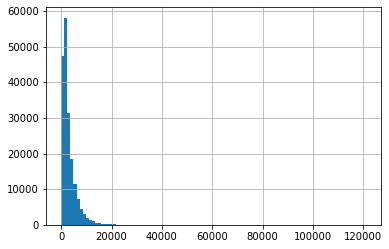

In [6]:
train['loss'].hist(bins=100);

Jak widać, jest to dość klasyczny skrzywiony rozkład... Raczej są dość duże wartości odstające po prawej stronie, dlatego usuńmy np. 1% danych po prawej stronie (czyli *percentile* 99).

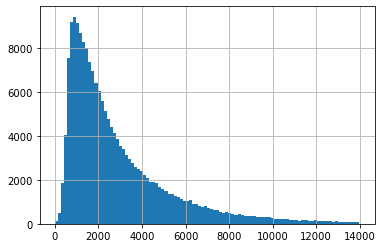

In [7]:
train[ train.loss < np.percentile(train.loss, 99) ]['loss'].hist(bins=100);

Mam nadzieję, że jak patrzysz na ten wykres, już chcesz zrobić transformację logarytmiczną, prawda? :) 

Zatem zróbmy ją.

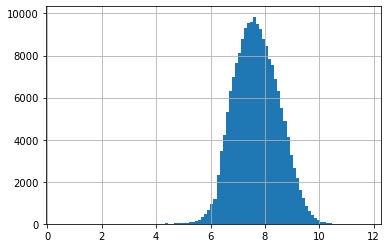

In [8]:
train['log_loss'] = np.log( train['loss'] + 1 ) #pamiętaj o +1 albo spróbuj np.log(0) w osobnej komórce
train['log_loss'].hist(bins=100);

Podpowiem Ci od razu jeszcze jeden "trick". Po tej transformacji po lewej stronie jest trochę słupków lokalnych. 

Już Ci to pokazuję.

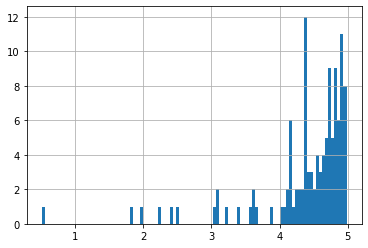

In [9]:
train[ train.log_loss < 5 ]['log_loss'].hist(bins=100);

Miał był rozkład symetryczny, natomiast tutaj jest jakiś szum, który będzie przeszkadzać (pierwsza wartość zaczyna się ok. 0.5, potem jest przerwa i następnie ok. 2 potem znów trochę przerw itd). Żeby temu zapobiec, można w logarytmie dodać coś więcej niż 1, np. 100. Ten parametr można dobierać oczywiście wg metryki sukcesu.

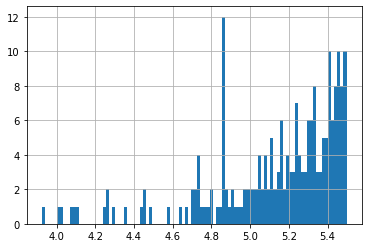

In [10]:
train['log_loss'] = np.log( train['loss'] + 50 )
train[ train.log_loss < 5.5 ]['log_loss'].hist(bins=100);

Popatrzmy teraz jeszcze raz na całość - już wygląda super, prawda?

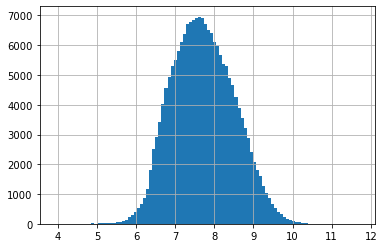

In [11]:
train['log_loss'].hist(bins=100);

## Zmienne kategorialne
Mają przedrostek w nazwie `cat`

In [12]:
cat_feats = [feat for feat in train.columns if 'cat' in feat]
print(len(cat_feats),  cat_feats)

116 ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'ca

Popatrzmy, ile jest unikalnych wartości w poszczególnych zmiennych.

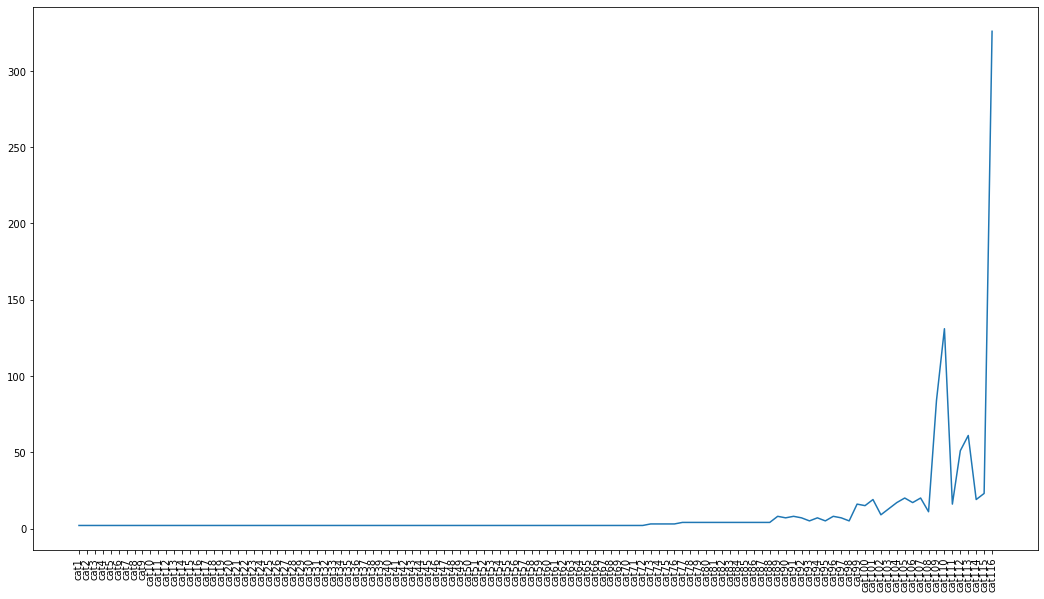

In [13]:
unq_values = [train[feat].nunique() for feat in cat_feats]

id_cat_feats = range(len(cat_feats))
plt.figure(figsize=(18, 10))
plt.plot(id_cat_feats, unq_values)
plt.xticks(id_cat_feats, cat_feats, rotation='vertical');

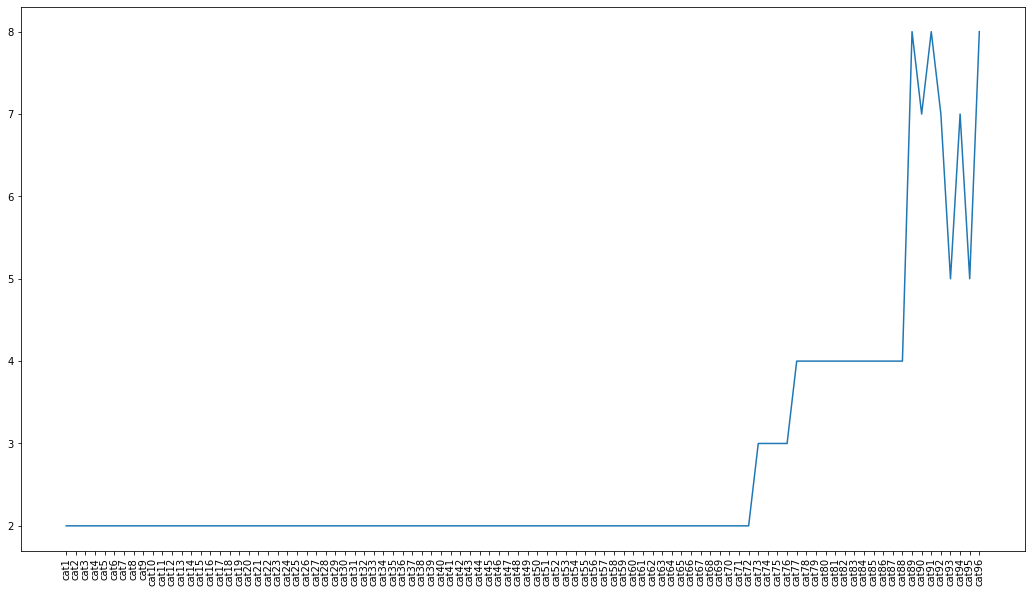

In [14]:
cut_last_elems = 20
plt.figure(figsize=(18, 10))
plt.plot(id_cat_feats[:-cut_last_elems], unq_values[:-cut_last_elems])
plt.xticks(id_cat_feats[:-cut_last_elems], cat_feats[:-cut_last_elems], rotation='vertical');

## Zmienne ciągłe
Mają przedrostek `cont`

In [15]:
cont_feats = [feat for feat in train.columns if 'cont' in feat]
print(len(cont_feats),  cont_feats)

14 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


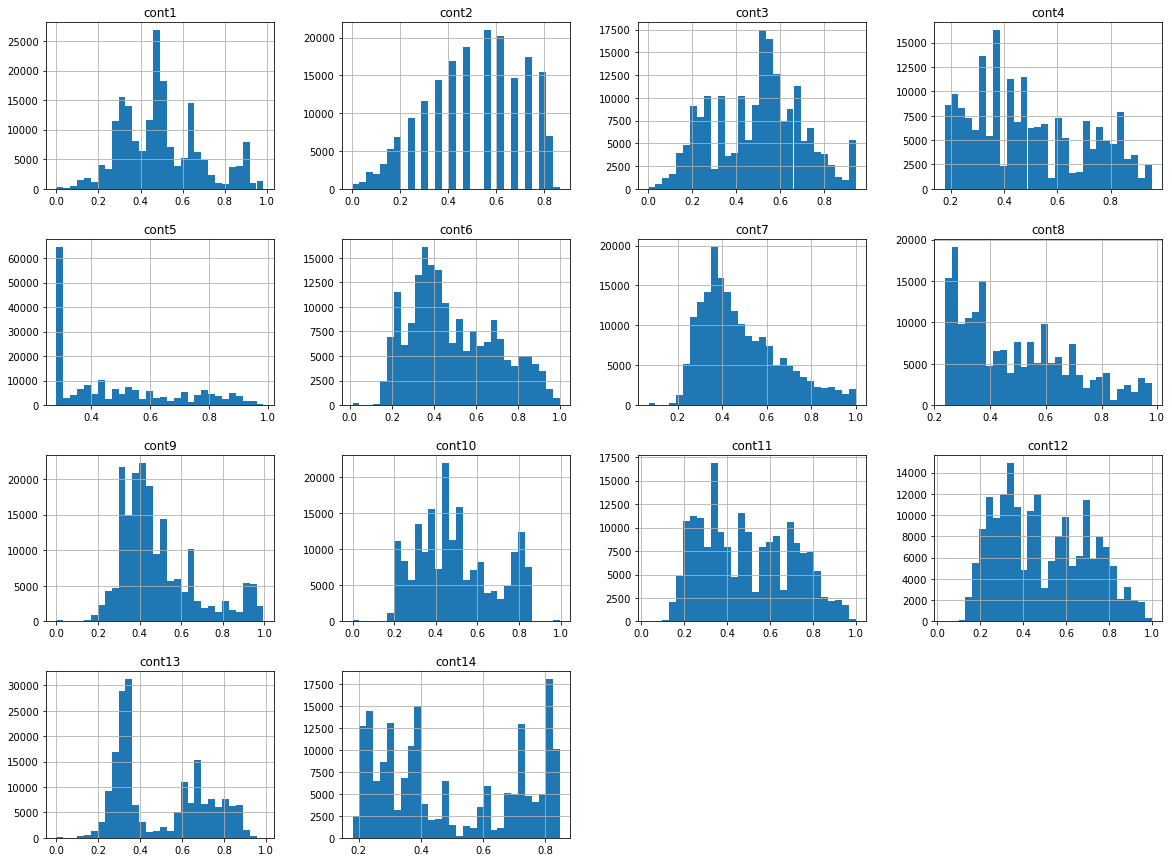

In [16]:
train[ cont_feats ].hist(bins=30, figsize=(20, 15));

## Evaluation
Metryką sukcesu będzie **[Mean absolute error](https://bit.ly/3sMlrpF)**.

## Baseline
Zbudujmy najprostszy model. 

In [17]:
def base_line_model(train, target_variable='loss', strategy='mean'):
    X = train[cont_feats].values
    y = train[target_variable].values

    model = DummyRegressor(strategy=strategy)
    model.fit(X, y)
    y_pred = model.predict(X)

    if target_variable == 'log_loss':
        y = np.exp(y) - 1
        y_pred = np.exp(y_pred) - 1
        y_pred[ y_pred < 0 ] = 0

    score = mean_absolute_error(y, y_pred)
        
    return score

for strategy in ['mean', 'median']:
    for target_variable in ['loss', 'log_loss']:
        score = base_line_model(train, target_variable=target_variable, strategy=strategy)
        print(strategy, target_variable, score)

mean loss 1966.1652855607203
mean log_loss 1810.3605106176383
median loss 1809.0487864675706
median log_loss 1809.0487864675708


## Przygotujmy dane dla sieci

In [18]:
df_train = train.sample(10000) #zmniejszamy ilość danych, żeby szybciej liczyło się
y = df_train['log_loss'].values

## Zmienne kategorialne

In [19]:
sparse_data = []

feat_cats = [f for f in df_train.columns if 'cat' in f]
for feat in feat_cats:
    dummy = pd.get_dummies(df_train[feat].astype('category'))
    tmp = csr_matrix(dummy)
    sparse_data.append(tmp)

## Zmienne ciągłe

In [20]:
f_num = [f for f in df_train.columns if 'cont' in f]
scaler = StandardScaler()
tmp = csr_matrix(scaler.fit_transform(df_train[f_num]))
sparse_data.append(tmp)

X = hstack(sparse_data, format = 'csr')
X

<10000x914 sparse matrix of type '<class 'numpy.float32'>'
	with 1300000 stored elements in Compressed Sparse Row format>

## Architektura
W sieci zastosowaliśmy warstwę Dense (czyli połączenia każdy z każdym), również pojawił **Dropout**.

Pojawiły się także nowe pojęcia:
- **BatchNormalization**
- funkcja aktywacja **PReLU**

BN (BatchNormalizaiton) pomaga walczyć z przeuczeniem się, ale również, jak pokazuje praktyka, potrafi przyspieszyć czas na naukę sieci.

PReLU to jest zmodyfikowana funkcja aktywacji ReLU (która zwracała zawsze 0 dla wszystkich wartości ujemnych).

![](../images/prelu.png)

In [21]:
def nn_model(input_dim):
    model = Sequential()

    model.add(Dense(400, input_dim = input_dim))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.45))

    model.add(Dense(200))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(50))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss = 'mae', optimizer = 'adam')
    return(model)

## Generatory

Poniżej jest trochę kodu, ale nie przejmuj się tym - idea jest bardzo prosta. W praktyce zwykle danych dla sieci neuronowych jest sporo (musi tyle być). Wczytanie ich wszystkich do pamięci jest mało efektywne, ale również czasem nie da się inaczej (nie mieszczą się).

Dlatego dane wczytuje się paczkami.


In [22]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])

    if shuffle:
        np.random.shuffle(sample_index)
        
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch

        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0
            
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0

## Uruchamiamy trenowanie

In [23]:
nepochs = 4
nfolds = 3

cv = KFold(n_splits=nfolds, shuffle = True, random_state = 2019)

for num_iter, (train_index, test_index) in enumerate(cv.split(y)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test   = X[test_index], y[test_index]
        
    model = nn_model(X_train.shape[1])

    model.fit(batch_generator(X_train, y_train, 128, True),
                                  epochs = nepochs,
                                  steps_per_epoch = 100,
                                  validation_data=(X_test.todense(), y_test),
                                  validation_steps=62.5,
                                  verbose = 2) 
    
    y_pred = np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0])

    score = mean_absolute_error(np.exp(y_test), y_pred)
    print("Fold{0}, score={1}".format(num_iter+1, score))

2022-10-18 13:26:10.717353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/4
100/100 - 3s - loss: 7.1715 - val_loss: 6.8714 - 3s/epoch - 26ms/step
Epoch 2/4
100/100 - 1s - loss: 4.9503 - 802ms/epoch - 8ms/step
Epoch 3/4
100/100 - 1s - loss: 1.9992 - 825ms/epoch - 8ms/step
Epoch 4/4
100/100 - 1s - loss: 1.2960 - 807ms/epoch - 8ms/step


/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_84017/2962722046.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0])


Fold1, score=1634.4840805802462
Epoch 1/4
100/100 - 2s - loss: 7.1146 - val_loss: 6.7120 - 2s/epoch - 20ms/step
Epoch 2/4
100/100 - 1s - loss: 4.8363 - 767ms/epoch - 8ms/step
Epoch 3/4
100/100 - 1s - loss: 1.9867 - 814ms/epoch - 8ms/step
Epoch 4/4
100/100 - 1s - loss: 1.3298 - 851ms/epoch - 9ms/step


/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_84017/2962722046.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0])


Fold2, score=1844.3859590144807
Epoch 1/4
100/100 - 2s - loss: 7.0922 - val_loss: 6.0995 - 2s/epoch - 19ms/step
Epoch 2/4
100/100 - 1s - loss: 4.7742 - 1s/epoch - 10ms/step
Epoch 3/4
100/100 - 1s - loss: 1.9803 - 1s/epoch - 10ms/step
Epoch 4/4
100/100 - 1s - loss: 1.3389 - 1s/epoch - 12ms/step


/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_84017/2962722046.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = np.exp(model.predict_generator(generator = batch_generatorp(X_test, 128, False), steps = X_test.shape[0])[:,0])


Fold3, score=1842.1715337226474
